In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display, HTML

opts = rdMolDraw2D.MolDrawOptions()
#opts.legendFontSize     = 10
opts.annotationFontScale = 1

def annotate_ligand_grid(
    df,
    ligand_col: str = "ligand_name",
    smiles_col: str = "smiles",
    rpos_col: str = "rpos",
    energy_col: str = "dE",
    cols: int = 3,
    subImgSize: tuple = (300, 300)
):
    """
    Group df by ligand_col, annotate each ligand at all its rpos with energy_col,
    and draw them in a grid.

    Returns an RDKit PIL image.
    """
    mols = []
    legends = []
    highlights = []

    for ligand, grp in df.groupby(ligand_col):
        smi       = grp[smiles_col].iloc[0]
        pos_list  = grp[rpos_col].tolist()
        e_list    = grp[energy_col].tolist()

        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            raise ValueError(f"Invalid SMILES for {ligand}: {smi}")

        for pos, e in zip(pos_list, e_list):
            mol.GetAtomWithIdx(pos).SetProp("atomNote", f"{e:.2f}")

        mols.append(mol)
        legends.append(f"{ligand}: " + ", ".join(f"{p}={e:.2f}" for p, e in zip(pos_list, e_list)))
        highlights.append(pos_list)

    grid = Draw.MolsToGridImage(
        mols,
        legends=legends,
        highlightAtomLists=highlights,
        molsPerRow=cols,
        subImgSize=subImgSize,
        maxMols=len(mols),
        returnPNG=False,
        drawOptions=opts
    )
    return grid


def _svg_annotated_smi(
        smi, pos_list, dE_list,
        size=(250, 250), highlight_color=(1, 0, 0)):
    """Return an SVG string of the molecule with per-atom ΔE labels."""

    mol = Chem.MolFromSmiles(smi)
    rdDepictor.Compute2DCoords(mol)

    for p, e in zip(pos_list, dE_list):
        mol.GetAtomWithIdx(int(p)).SetProp("atomNote", f"{e:.2f}")

    drawer = rdMolDraw2D.MolDraw2DSVG(*size)
    opts = drawer.drawOptions()
    opts.drawAtomNotes       = True
    opts.annotationFontScale = 0.9 

    drawer.DrawMolecule(
        mol,
        #highlightAtoms      =[int(p) for p in pos_list],
        #highlightAtomColors ={int(p): highlight_color for p in pos_list},
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

def build_annotated_frame(df,
                          ligand_col="ligand_name",
                          smi_col="smiles",
                          pos_col="rpos",
                          energy_col="dE"):
    """One row per ligand + an SVG column with all ΔE annotations."""
    rows = []
    for lig, grp in df.groupby(ligand_col):
        smi  = grp[smi_col].iloc[0]
        pos  = grp[pos_col].astype(int).tolist()
        dE   = grp[energy_col].tolist()
        svg  = _svg_annotated_smi(smi, pos, dE)
        rows.append({ligand_col: lig, smi_col: smi, "annotated_svg": svg})
    return pd.DataFrame(rows)

In [5]:
conversion_factor       =  627.509474
dimer_dft               = -834847.294
HBpin_dft               = -258305.91711374212
H2_dft                  = -737.1088023791428

dimer_xtb               = -97.050557670754 * conversion_factor
HBpin_xtb               = -28.947535986441 * conversion_factor
H2_xtb                  = -0.9826859256890 * conversion_factor

In [6]:
print(dimer_dft/dimer_xtb)
print(HBpin_dft/HBpin_xtb)
print(H2_dft/H2_xtb)

13.708461651255337
14.220093934686332
1.1953540969495426


In [7]:
H2_xtb

-616.6447283363075

In [8]:
import pyarrow.parquet as pq

schema = pq.read_schema("output_files/font_ts2.parquet")
schema.field_by_name

<bound method Schema.field_by_name of custom_name: string
ligand_name: string
rpos: int64
constraint_atoms: list<element: int64>
  child 0, element: int64
cid: int64
smiles: string
atoms: list<element: string>
  child 0, element: string
coords_embedded: list<element: list<element: double>>
  child 0, element: list<element: double>
      child 0, element: double
energy_uff: double
xtb-gfnff-opt-electronic_energy: double
xtb-gfnff-opt-normal_termination: bool
xtb-gfnff-opt-opt_coords: list<element: list<element: double>>
  child 0, element: list<element: double>
      child 0, element: double
xtb-gfn-electronic_energy: double
xtb-gfn-normal_termination: bool
xtb-gfn-opt-electronic_energy: double
xtb-gfn-opt-normal_termination: bool
xtb-gfn-opt-opt_coords: list<element: list<element: double>>
  child 0, element: list<element: double>
      child 0, element: double
DFT-wB97X-D3-6-31G**-OptTS-electronic_energy: double
DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy: double
DFT-wB97X-D3-6-31G**-OptT

In [10]:
df_lig = pd.read_parquet(
    "output_files/font_ligs.parquet",
    columns=[
        "ligand_name",        
        "orca-wB97X-D3-6-31G**-Freq-electronic_energy",
        "orca-wB97X-D3-6-31G**-Freq-gibbs_energy",
        "orca-wB97X-D3-6-31+G**-NoSym-electronic_energy",
    ],
)
df_ts2 = pd.read_parquet(
    "output_files/font_ts2.parquet",
    columns=[
        "ligand_name",
        "rpos",
        "atoms",
        "xtb-gfn-opt-opt_coords",
        "DFT-wB97X-D3-6-31G**-OptTS-opt_coords",
        "DFT-wB97X-D3-6-31G**-OptTS-electronic_energy",
        "DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy",
        "DFT-SP-wB97X-D3-6-31+G**-NoSym-electronic_energy",
    ],
)

In [13]:
df = df_ts2.merge(df_lig, on='ligand_name', how='left', suffixes=('_ts', '_lig'))

In [14]:
df

,ligand_name,rpos,atoms,xtb-gfn-opt-opt_coords,DFT-wB97X-D3-6-31G**-OptTS-opt_coords,DFT-wB97X-D3-6-31G**-OptTS-electronic_energy,DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy,DFT-SP-wB97X-D3-6-31+G**-NoSym-electronic_energy,orca-wB97X-D3-6-31G**-Freq-electronic_energy,orca-wB97X-D3-6-31G**-Freq-gibbs_energy,orca-wB97X-D3-6-31+G**-NoSym-electronic_energy
0,2-tert-butylfuran,3,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[2.10843977464913, 1.53355299887061, -1.06172...","[[2.023471, 1.60637, -1.093861], [2.037298, 1....",-1463.304014,-1462.634617,-1463.358288,-387.198040,-387.046391,-387.217271
1,2-tert-butylfuran,4,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[-1.44435080426548, -1.97157174350055, 1.4339...","[[-1.404402, -2.005641, 1.41211], [-0.369695, ...",-1463.310109,-1462.639852,-1463.366755,-387.198040,-387.046391,-387.217271
2,2-tert-butylfuran,5,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[2.49539716028309, -1.37445501336823, -0.0558...","[[2.255091, -1.279854, -0.422049], [1.82698, 0...",-1463.305205,-1462.637110,-1463.364544,-387.198040,-387.046391,-387.217271
3,tri(propan-2-yl)-pyrrol-1-ylsilane,4,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[-2.14173229932197, -2.19722502841278, -1.001...","[[-2.334549, -2.184869, -0.891462], [-1.897449...",-1930.707141,-1929.868740,-1930.768204,-854.599638,-854.283616,-854.629311
4,tri(propan-2-yl)-pyrrol-1-ylsilane,5,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[-2.24718499295148, 2.23910452140363, -1.7090...","[[-1.909211, 1.549947, -2.025], [-1.025065, 0....",-1930.719291,-1929.881562,-1930.784719,-854.599638,-854.283616,-854.629311
5,2-methylfuran,2,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[2.59994526948863, -0.71435929768808, 0.43371...","[[2.396807, -0.716747, 0.329816], [1.710981, 0...",-1345.382565,-1344.793687,-1345.438360,-269.273972,-269.203328,-269.290542
6,2-methylfuran,3,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[-1.64805183729801, 0.6162068935864, -2.13932...","[[-1.579403, 0.523229, -1.905458], [-0.187477,...",-1345.382142,-1344.794214,-1345.439689,-269.273972,-269.203328,-269.290542
7,2-methylfuran,4,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[1.64837943007253, 1.59024359392811, -0.44429...","[[1.660629, 1.582457, -0.491425], [0.419134, 1...",-1345.394067,-1344.805962,-1345.449779,-269.273972,-269.203328,-269.290542
8,2-methoxyfuran,3,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[1.04129490809291, -0.33716275110345, -2.5539...","[[0.856853, -0.307716, -2.415623], [-0.175157,...",-1420.571660,-1419.978790,-1420.627891,-344.451908,-344.377185,-344.470382
9,2-methoxyfuran,4,"[C, C, C, C, C, C, H, H, H, H, N, C, C, C, C, ...","[[1.92892441030881, 0.64404517388429, 1.782035...","[[1.786057, 0.571522, 1.557011], [0.427168, 0....",-1420.554652,-1419.964269,-1420.613309,-344.451908,-344.377185,-344.470382


In [300]:
energy_cols = [col for col in df.columns if 'energy' in col]
df[energy_cols] = df[energy_cols] * conversion_factor

In [301]:
df["lig_G_corr"] = df["orca-wB97X-D3-6-31G**-Freq-gibbs_energy"] - df["orca-wB97X-D3-6-31G**-Freq-electronic_energy"]
df["lig_G"] = df["orca-wB97X-D3-6-31+G**-NoSym-electronic_energy"] + df["lig_G_corr"]

df["ts_G_corr"] = df["DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy"] - df["DFT-wB97X-D3-6-31G**-OptTS-electronic_energy"]
df["ts_G"] = df["DFT-SP-wB97X-D3-6-31+G**-NoSym-electronic_energy"] + df["ts_G_corr"]

In [302]:
df

,ligand_name,rpos,DFT-wB97X-D3-6-31G**-OptTS-electronic_energy,DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy,DFT-SP-wB97X-D3-6-31+G**-NoSym-electronic_energy,orca-wB97X-D3-6-31G**-Freq-electronic_energy,orca-wB97X-D3-6-31G**-Freq-gibbs_energy,orca-wB97X-D3-6-31+G**-NoSym-electronic_energy,lig_G_corr,lig_G,ts_G_corr,ts_G
0,2-tert-butylfuran,3,-9.182371e+05,-9.178171e+05,-9.182712e+05,-242970.438266,-242875.277224,-242982.505937,95.161042,-242887.344895,420.053114,-9.178511e+05
1,2-tert-butylfuran,4,-9.182410e+05,-9.178204e+05,-9.182765e+05,-242970.438266,-242875.277224,-242982.505937,95.161042,-242887.344895,420.592357,-9.178559e+05
2,2-tert-butylfuran,5,-9.182379e+05,-9.178186e+05,-9.182751e+05,-242970.438266,-242875.277224,-242982.505937,95.161042,-242887.344895,419.235751,-9.178559e+05
3,tri(propan-2-yl)-pyrrol-1-ylsilane,4,-1.211537e+06,-1.211011e+06,-1.211575e+06,-536269.369272,-536071.062623,-536287.989122,198.306648,-536089.682474,526.105081,-1.211049e+06
4,tri(propan-2-yl)-pyrrol-1-ylsilane,5,-1.211545e+06,-1.211019e+06,-1.211586e+06,-536269.369272,-536071.062623,-536287.989122,198.306648,-536089.682474,525.683039,-1.211060e+06
5,2-methylfuran,2,-8.442403e+05,-8.438708e+05,-8.442753e+05,-168971.968668,-168927.638834,-168982.366517,44.329834,-168938.036684,369.526504,-8.439058e+05
6,2-methylfuran,3,-8.442400e+05,-8.438711e+05,-8.442762e+05,-168971.968668,-168927.638834,-168982.366517,44.329834,-168938.036684,368.930884,-8.439072e+05
7,2-methylfuran,4,-8.442475e+05,-8.438785e+05,-8.442825e+05,-168971.968668,-168927.638834,-168982.366517,44.329834,-168938.036684,369.041699,-8.439134e+05
8,2-methoxyfuran,3,-8.914222e+05,-8.910501e+05,-8.914575e+05,-216146.835578,-216099.945953,-216158.428382,46.889624,-216111.538758,372.031590,-8.910854e+05
9,2-methoxyfuran,4,-8.914115e+05,-8.910410e+05,-8.914483e+05,-216146.835578,-216099.945953,-216158.428382,46.889624,-216111.538758,370.470628,-8.910778e+05


In [303]:
df["dG"] = (2 * (df["ts_G"] - df["lig_G"] - HBpin_dft + H2_dft) - dimer_dft) / 2

In [304]:
df.sort_values(by="ligand_name")

,ligand_name,rpos,DFT-wB97X-D3-6-31G**-OptTS-electronic_energy,DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy,DFT-SP-wB97X-D3-6-31+G**-NoSym-electronic_energy,orca-wB97X-D3-6-31G**-Freq-electronic_energy,orca-wB97X-D3-6-31G**-Freq-gibbs_energy,orca-wB97X-D3-6-31+G**-NoSym-electronic_energy,lig_G_corr,lig_G,ts_G_corr,ts_G,dG
26,1-benzylpyrrole,9,-9.767308e+05,-9.763053e+05,-9.767778e+05,-301459.533212,-301358.749690,-301482.394037,100.783522,-301381.610515,425.477364,-9.763523e+05,21.772998
25,1-benzylpyrrole,8,-9.767385e+05,-9.762436e+05,-9.767817e+05,-301459.533212,-301358.749690,-301482.394037,100.783522,-301381.610515,494.925839,-9.762867e+05,87.332910
24,1-benzylpyrrole,5,-9.767263e+05,-9.763000e+05,-9.767711e+05,-301459.533212,-301358.749690,-301482.394037,100.783522,-301381.610515,426.335133,-9.763447e+05,29.345357
23,1-benzylpyrrole,4,-9.767310e+05,-9.762307e+05,-9.767757e+05,-301459.533212,-301358.749690,-301482.394037,100.783522,-301381.610515,500.325109,-9.762753e+05,98.722116
22,1-benzylpyrrole,3,-9.767286e+05,-9.762337e+05,-9.767703e+05,-301459.533212,-301358.749690,-301482.394037,100.783522,-301381.610515,494.891407,-9.762754e+05,98.617137
15,1-methylindole,5,-9.281664e+05,-9.277609e+05,-9.282087e+05,-252901.357120,-252821.433787,-252919.093314,79.923333,-252839.169981,405.507569,-9.278032e+05,28.411463
17,1-methylindole,7,-9.281670e+05,-9.277619e+05,-9.282061e+05,-252901.357120,-252821.433787,-252919.093314,79.923333,-252839.169981,405.015428,-9.278011e+05,30.507617
16,1-methylindole,6,-9.281629e+05,-9.277582e+05,-9.282052e+05,-252901.357120,-252821.433787,-252919.093314,79.923333,-252839.169981,404.668504,-9.278005e+05,31.079705
14,1-methylindole,4,-9.281642e+05,-9.277585e+05,-9.282054e+05,-252901.357120,-252821.433787,-252919.093314,79.923333,-252839.169981,405.719584,-9.277996e+05,31.979473
19,1-methylindole,9,-9.281752e+05,-9.277709e+05,-9.282143e+05,-252901.357120,-252821.433787,-252919.093314,79.923333,-252839.169981,404.329920,-9.278100e+05,21.662953


In [306]:
df_lig_xtb = pd.read_parquet(
    "output_files/font_ligs.parquet",
    columns=[
        "ligand_name",
        "xtb-gfn-opt-electronic_energy",
    ],
)

df_ts2_xtb = pd.read_parquet(
    "output_files/font_ts2.parquet",
    columns=[
        "ligand_name",
        "rpos",
        "xtb-gfn-opt-electronic_energy",
    ],
)

In [307]:
df_lig_xtb.rename(columns={"xtb-gfn-opt-electronic_energy": "xtb-gfn2-lig_energy"}, inplace=True)

In [308]:
df_ts2_xtb.rename(columns={"xtb-gfn-opt-electronic_energy": "xtb-gfn2-ts2_energy"}, inplace=True)

In [309]:
df_ts2_xtb

,ligand_name,rpos,xtb-gfn2-ts2_energy
0,2-tert-butylfuran,3,-102.589357
1,2-tert-butylfuran,4,-102.591043
2,2-tert-butylfuran,5,-102.592870
3,tri(propan-2-yl)-pyrrol-1-ylsilane,4,-120.526161
4,tri(propan-2-yl)-pyrrol-1-ylsilane,5,-120.530328
5,2-methylfuran,2,-93.094010
6,2-methylfuran,3,-93.094712
7,2-methylfuran,4,-93.097662
8,2-methoxyfuran,3,-97.158426
9,2-methoxyfuran,4,-97.155186


In [310]:
df_xtb = df_ts2_xtb.merge(df_lig_xtb, how="left", on="ligand_name", suffixes=('_ts', '_lig'))
energy_cols = [col for col in df_xtb.columns if 'energy' in col]
df_xtb[energy_cols] = df_xtb[energy_cols] * conversion_factor
df_xtb = df_xtb[~((df_xtb['ligand_name'] == 'trimethyl(pyrrol-1-yl)silane') & (df_xtb['rpos'] == 4))]
df_xtb

,ligand_name,rpos,xtb-gfn2-ts2_energy,xtb-gfn2-lig_energy
0,2-tert-butylfuran,3,-64375.793314,-17140.369180
1,2-tert-butylfuran,4,-64376.851682,-17140.369180
2,2-tert-butylfuran,5,-64377.997866,-17140.369180
3,tri(propan-2-yl)-pyrrol-1-ylsilane,4,-75631.307908,-28393.563866
4,tri(propan-2-yl)-pyrrol-1-ylsilane,5,-75633.922431,-28393.563866
5,2-methylfuran,2,-58417.372988,-11179.960296
6,2-methylfuran,3,-58417.813522,-11179.960296
7,2-methylfuran,4,-58419.665112,-11179.960296
8,2-methoxyfuran,3,-60967.832943,-13729.117474
9,2-methoxyfuran,4,-60965.799467,-13729.117474


In [311]:
df_xtb["dE"] = (2 * (df_xtb["xtb-gfn2-ts2_energy"] - df_xtb["xtb-gfn2-lig_energy"] - HBpin_xtb + H2_xtb) - dimer_xtb) / 2

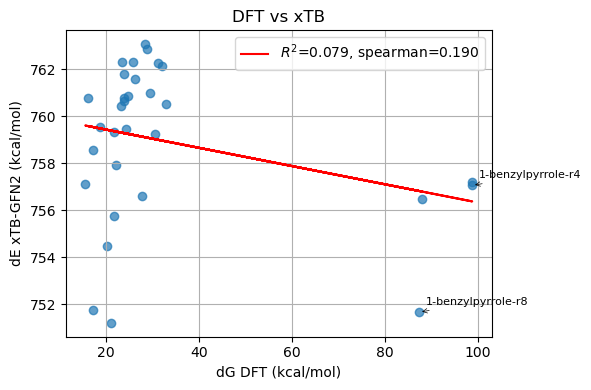

In [312]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress, spearmanr

method = 'spearman'  # or 'spearman'

df1 = df[['ligand_name','rpos','dG']].copy()
df2 = df_xtb[['ligand_name','rpos','dE']].copy()
merged = pd.merge(df1, df2, on=['ligand_name','rpos'], how='inner')
#merged = merged.drop(merged["dG"].nlargest(4).index)

x = merged['dG']
y = merged['dE']
slope, intercept, r_val, p_val, stderr = linregress(x, y)
y_fit = slope * x + intercept
rho, _ = spearmanr(x, y)

if method == 'pearson':
    merged['score'] = (y - y_fit).abs()
elif method == 'spearman':
    merged['rank_dG'] = merged['dG'].rank()
    merged['rank_dE'] = merged['dE'].rank()
    merged['score'] = (merged['rank_dE'] - merged['rank_dG']).abs()

outliers = merged.nlargest(2, 'score')

plt.figure(figsize=(6, 4))
plt.scatter(x, y, alpha=0.7)
plt.plot(x, y_fit, color='red', label=f"$R^2$={r_val**2:.3f}, spearman={rho:.3f}")

for _, row in outliers.iterrows():
    lbl = f"{row['ligand_name']}-r{int(row['rpos'])}"
    plt.annotate(lbl, (row['dG'], row['dE']),
                 textcoords="offset points", xytext=(5,5),
                 ha='left', fontsize=8, arrowprops=dict(arrowstyle="->", lw=0.5))

plt.xlabel("dG DFT (kcal/mol)")
plt.ylabel("dE xTB-GFN2 (kcal/mol)")
plt.title("DFT vs xTB")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [313]:
merged.sort_values(by="dG", ascending=False)


,ligand_name,rpos,dG,dE,rank_dG,rank_dE,score
23,1-benzylpyrrole,4,98.722116,757.060380,31.0,8.0,23.0
22,1-benzylpyrrole,3,98.617137,757.208655,30.0,10.0,20.0
28,furan-2-yloxy(trimethyl)silane,5,88.010030,756.468247,29.0,6.0,23.0
25,1-benzylpyrrole,8,87.332910,751.662437,28.0,2.0,26.0
3,tri(propan-2-yl)-pyrrol-1-ylsilane,4,32.903006,760.536508,27.0,18.0,9.0
14,1-methylindole,4,31.979473,762.151264,26.0,26.0,0.0
16,1-methylindole,6,31.079705,762.276199,25.0,27.0,2.0
17,1-methylindole,7,30.507617,759.229855,24.0,13.0,11.0
24,1-benzylpyrrole,5,29.345357,760.984421,23.0,23.0,0.0
0,2-tert-butylfuran,3,28.663436,762.856416,22.0,30.0,8.0
